In [106]:
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import lightgbm as lgbm

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler


In [2]:
df = pd.read_csv('dataset_SCL.csv')

c:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (1,6) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [ ]:
'''
Detalle de variables:

Fecha-I : Fecha y hora programada del vuelo.
Vlo-I : Número de vuelo programado.
Ori-I : Código de ciudad de origen programado.
Des-I : Código de ciudad de destino programado.
Emp-I : Código aerolínea de vuelo programado.
Fecha-O : Fecha y hora de operación del vuelo.
Vlo-O : Número de vuelo de operación del vuelo.
Ori-O : Código de ciudad de origen de operación
Des-O : Código de ciudad de destino de operación.
Emp-O : Código aerolínea de vuelo operado.
DIA : Día del mes de operación del vuelo.
MES : Número de mes de operación del vuelo.
AÑO : Año de operación del vuelo.
DIANOM : Día de la semana de operación del vuelo.
TIPOVUELO : Tipo de vuelo, I =Internacional, N =Nacional.
OPERA : Nombre de aerolínea que opera.
SIGLAORI : Nombre ciudad origen.
SIGLADES : Nombre ciudad destino.
'''

In [3]:
df.head()

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,1,1,2017,Domingo,I,American Airlines,Santiago,Miami
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,2,1,2017,Lunes,I,American Airlines,Santiago,Miami
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,3,1,2017,Martes,I,American Airlines,Santiago,Miami
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,4,1,2017,Miercoles,I,American Airlines,Santiago,Miami
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,5,1,2017,Jueves,I,American Airlines,Santiago,Miami


# Desafío

##### 1. ¿Cómo se distribuyen los datos? ¿Qué te llama la atención o cuál es tu conclusión sobre esto?

El dataset cuenta con 68.206 filas y 18 columnas

In [4]:
df.shape

(68206, 18)

Tenemos solo un dato nulo en el campo 'Vlo-O' (Número de vuelo de operación del vuelo.)

In [5]:
df.isnull().sum()

Fecha-I      0
Vlo-I        0
Ori-I        0
Des-I        0
Emp-I        0
Fecha-O      0
Vlo-O        1
Ori-O        0
Des-O        0
Emp-O        0
DIA          0
MES          0
AÑO          0
DIANOM       0
TIPOVUELO    0
OPERA        0
SIGLAORI     0
SIGLADES     0
dtype: int64

In [6]:
df[df['Vlo-O'].isnull()]

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
6068,2017-01-19 11:00:00,200,SCEL,SPJC,LAW,2017-01-19 11:03:00,NaN,SCEL,SPJC,56R,19,1,2017,Jueves,I,Latin American Wings,Santiago,Lima


Podemos ver que en 97% de os casos el campo 'Vlo-O' es identico al campo 'Vlo-I', por lo tanto, para este caso nulo remplazaremos ese valor.

In [7]:
df[df['Vlo-O']==df['Vlo-I']].shape[0]/df.shape[0]

0.9728762865437058

In [8]:
df['Vlo-O'] = df['Vlo-O'].fillna(df['Vlo-I'])

Al ver los tipos de datos, vemos que predominan los datos categoricos. 

Tranformaremos los campos 'Fecha-I' y 'Fecha-O' de object a datetime

In [9]:
df.dtypes

Fecha-I      object
Vlo-I        object
Ori-I        object
Des-I        object
Emp-I        object
Fecha-O      object
Vlo-O        object
Ori-O        object
Des-O        object
Emp-O        object
DIA           int64
MES           int64
AÑO           int64
DIANOM       object
TIPOVUELO    object
OPERA        object
SIGLAORI     object
SIGLADES     object
dtype: object

In [10]:
df[["Fecha-I", "Fecha-O"]] = df[["Fecha-I", "Fecha-O"]].apply(pd.to_datetime)

El rango temporal de los vuelos porgramados corresponde a todo el año 2017, en los vuelos programados a última hora del 2017 desbordaron al al 1 de enero del 2018.

Al graficar los datos, se observan peaks en la epoca de verano, vavaciones de invierno y una disminución entre marzo y julio.

Los campos DIA, MES, AÑO, corresponden a la Fehca de operación. Crearemos campos similares para la Fecha Programada.

Más adelante observaremos en mayor detalle los cruces por tipo de vuelo, destinos, horarios, etc.

In [11]:
#creamos variables para fecha porgramada
df['Dia-I'] = df['Fecha-I'].dt.day
df['Mes-I'] = df['Fecha-I'].dt.month
df['Año-I'] = df['Fecha-I'].dt.year
df['DiaNom-I'] = df['Fecha-I'].dt.strftime('%A')

In [12]:
df.describe(datetime_is_numeric= True)

,Fecha-I,Fecha-O,DIA,MES,AÑO,Dia-I,Mes-I,Año-I
count,68206,68206,68206.000000,68206.000000,68206.000000,68206.000000,68206.000000,68206.0
mean,2017-07-05 12:11:25.320059648,2017-07-05 12:20:31.971380992,15.714790,6.622585,2017.000029,15.714321,6.622804,2017.0
min,2017-01-01 00:15:00,2017-01-01 00:04:00,1.000000,1.000000,2017.000000,1.000000,1.000000,2017.0
25%,2017-03-31 12:41:15,2017-03-31 12:51:15,8.000000,3.000000,2017.000000,8.000000,3.000000,2017.0
50%,2017-07-10 05:30:00,2017-07-10 05:37:00,16.000000,7.000000,2017.000000,16.000000,7.000000,2017.0
75%,2017-10-08 11:18:45,2017-10-08 11:19:45,23.000000,10.000000,2017.000000,23.000000,10.000000,2017.0
max,2017-12-31 23:55:00,2018-01-01 00:12:00,31.000000,12.000000,2018.000000,31.000000,12.000000,2017.0
std,NaN,NaN,8.782886,3.523321,0.005415,8.783229,3.523376,0.0


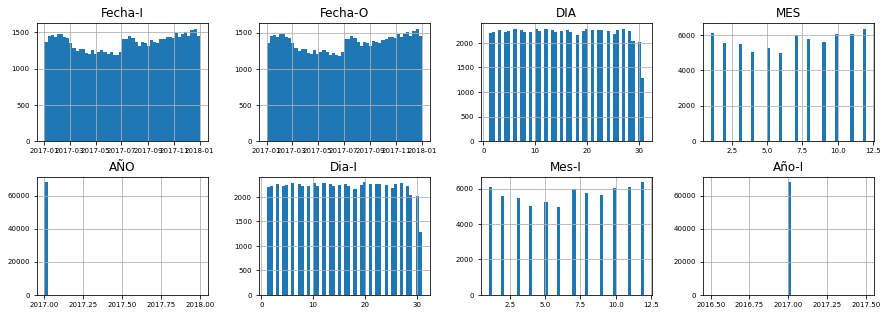

In [13]:
df.hist(figsize=(15, 5), bins=50, xlabelsize=7, ylabelsize=7, layout = (2,4));

Al analizar los datos categoricos vemos lo siguiente:

Tenemos 750 codigos de vuelos únicos en el campo 'Vlo-I' y 866 en el campo 'Vlo-O'. ¿Los vuelos con cambios de codigo implicaran algun atraso? Crearemos esa variable más adelante para validar.

Origene del vuelo: 'Ori-I', 'Ori-O', y SIGLAORI son todas únicas y hacen referencia a Santiago de forma consitente. Al momoento de modelar no consideraremso estas variable ya que no aportan información para discriminar.

Destinos del vuelo: 'Des-I' (64 únicos), 'Des-O' (63 únicos), SIGLADES (62 únicos). Al igual que con número de vuelo observaremos si hay diferencias en los destinos programados/operados y si tienen implicancia con atrasos.

Empresas: Emp-I(30 únicas), Emp-O(32 únicas) y OPERA (23 únicas). Veremos el porque de los distintos valores y si podemos quedarnos solo con 'Emp-I' al momento de entrenar el modelo.

Día del vuelo: DIANOM, contiene los 7 días de la semana, y el mayoritario es el día viernes.

Tipo de Vuelo: de los 68mil vuelos, 37mil son nacionales. 

**Aqui una nota sobre el problema: cuando estemos modelando si un vuelo tendrá atras o no, para evitar leak de información que no tendriamos a disposición en una caso real, no podemos considerar como variables predictoras las variables con '-O' ya que es información futura al momento de la programación de un vuelo.**


In [14]:
df.describe(include=['O']).transpose()


,count,unique,top,freq
Vlo-I,68206,750,174,686
Ori-I,68206,1,SCEL,68206
Des-I,68206,64,SCFA,5787
Emp-I,68206,30,LAN,37611
Vlo-O,68206,866,174,649
Ori-O,68206,1,SCEL,68206
Des-O,68206,63,SCFA,5786
Emp-O,68206,32,LAN,20988
DIANOM,68206,7,Viernes,10292
TIPOVUELO,68206,2,N,36966


A continuación exploraremos graficamente las  variables categoricas:

Destinos: Los destinos más frecuentes son Buenos Aires, Antofagasta, Lima, Calama y Puerto Montt. 

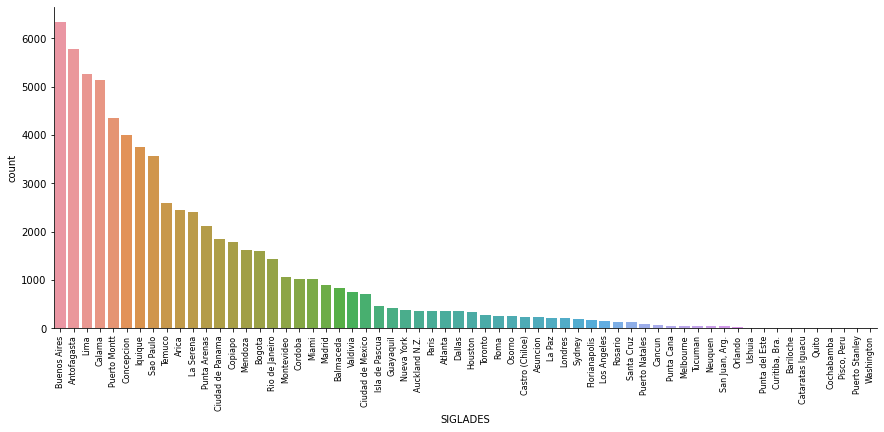

In [15]:
sns.catplot(data=df, 
            x='SIGLADES', 
            kind="count", 
            order = df['SIGLADES'].value_counts().index, 
            height=5, aspect=2.5)
plt.xticks(rotation=90, size = 8)
plt.show()

Un alternativa a explorar sería obtener la geolocalización de los destinos y calcular la distancia del vuelo.

Como hipotesis, Un vuelo de alta distancia deberia mover muchos más pasajeros y probablemente exista más probabilidad de atraso.

Una busqueda en google, nos muestra que en el siguiente sitio tenemos todos los aeropuertos con codigo y coordenadas:
https://ourairports.com/data/

In [16]:
aeropuertos = pd.read_csv('airports.csv')
#correción de aeropuerto de Perú https://ourairports.com/airports/SPIM/
aeropuertos['ident'] = np.where(aeropuertos['ident']=='SPIM', 'SPJC', aeropuertos['ident']) 

In [17]:
#Cruzamos la ubicacion de destino y origen
df = df.merge(aeropuertos[['ident','latitude_deg','longitude_deg']],
                         left_on='Des-I', right_on='ident', how='left')
df = df.merge(aeropuertos[['ident','latitude_deg','longitude_deg']],
                         left_on='Ori-I', right_on='ident', how='left')
#renombramos campos
df = df.rename(columns={'latitude_deg_x': 'latitud_des', 'longitude_deg_x': 'longitude_des',
                        'latitude_deg_y': 'latitud_ori', 'longitude_deg_y': 'longitude_ori'})
df = df.drop(['ident_x','ident_y'], axis = 1)

In [18]:
#Función para calcular distancia
#https://stackoverflow.com/questions/40452759/pandas-latitude-longitude-to-distance-between-successive-rows
def haversine(lat1, lon1, lat2, lon2, to_radians=True, earth_radius=6371):
    if to_radians:
        lat1, lon1, lat2, lon2 = np.radians([lat1, lon1, lat2, lon2])

    a = np.sin((lat2-lat1)/2.0)**2 + \
        np.cos(lat1) * np.cos(lat2) * np.sin((lon2-lon1)/2.0)**2

    return earth_radius * 2 * np.arcsin(np.sqrt(a))

In [19]:
df['distancia'] = haversine(df['latitud_des'],df['longitude_des'],df['latitud_ori'],df['longitude_ori']).round().astype(int)

La mayoría de los vuelos tienen una distancia de menos de 1.000km

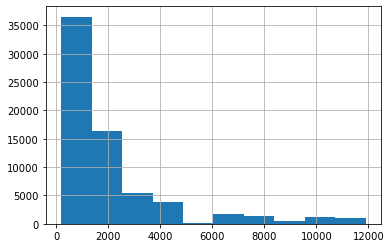

In [20]:
df.distancia.hist()
plt.show()

En vuelos nacionales tenemos 4 empresas, mientras que en Internacionales hay una alta cardinalidad.

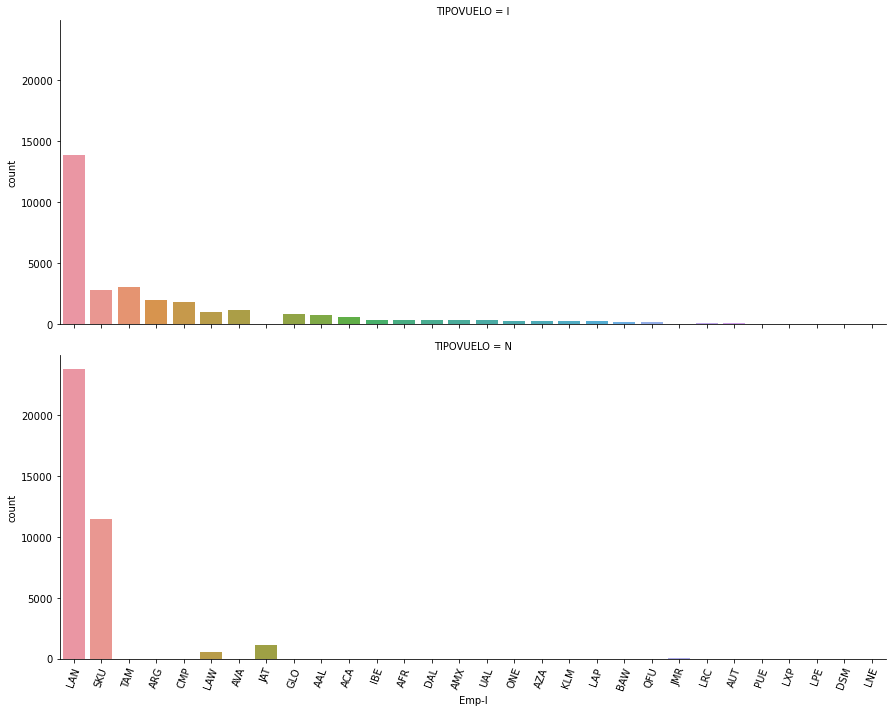

In [21]:
sns.catplot(data=df, 
            x='Emp-I', 
            kind="count", 
            row='TIPOVUELO',
            order = df['Emp-I'].value_counts().index, 
            height=5, aspect=2.5)
plt.xticks(rotation=70)
#plt.xlabel('Vlo-I',fontsize=1)
plt.tight_layout()

Viernes, Jueves y Lunes son los días con más vuelos. Sábado es el día menos cargado.

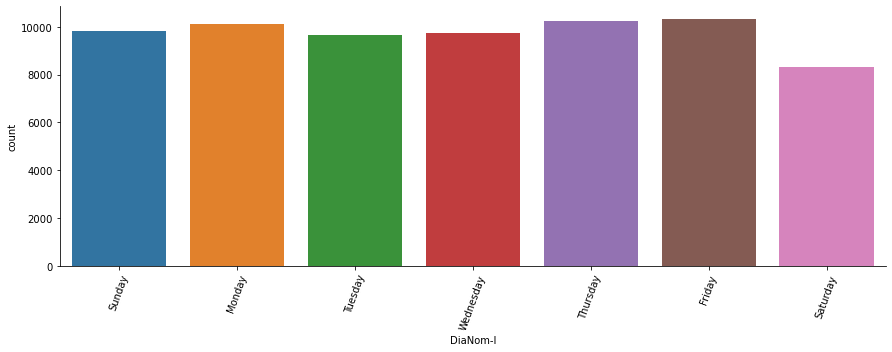

In [22]:
sns.catplot(data=df, 
            x='DiaNom-I', 
            kind="count",
            height=5, aspect=2.5)
plt.xticks(rotation=70)
#plt.xlabel('Vlo-I',fontsize=1)
plt.tight_layout()

##### 2. Genera las columnas adicionales y luego expórtelas en un archivo 'synthetic_features.csv'

In [23]:
#funcion que calcula temporada alta, requiere fechas en formato datetime.
def temporada_alta(fecha):
    fecha = datetime.date(year=1900, month=fecha.month, day=fecha.day)

    if   datetime.date(1900, 12, 15) <= fecha <= datetime.date(1900, 3, 3) or \
         datetime.date(1900, 7, 15) <= fecha <= datetime.date(1900, 7, 31) or \
         datetime.date(1900, 9, 11) <= fecha <= datetime.date(1900, 9, 30):

        return 1
    else:
        return 0       

In [24]:
#temporada_alta : 1 si Fecha-I está entre 15-Dic y 3-Mar, o 15-Jul y 31-Jul, o 11-Sep y 30-Sep, 0 si no.
df['temporada_alta'] = df.apply(lambda x: temporada_alta(x['Fecha-I']), axis=1)

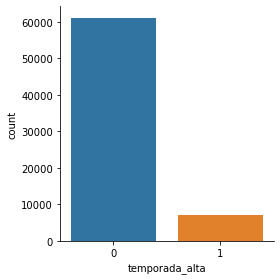

In [25]:
sns.catplot(data=df, 
            x='temporada_alta', 
            kind="count",
            height=4, aspect=1)
#plt.xticks(rotation=70)
#plt.xlabel('Vlo-I',fontsize=1)
plt.tight_layout()

In [26]:
#función para calcular diferencia en minutos, requiere fechas en formato datetime.
def diferencia_minutos(fecha_fin, fecha_ini):
    return int(round((fecha_fin - fecha_ini).total_seconds() / 60.0))

In [27]:
#dif_min : diferencia en minutos entre Fecha-O y Fecha-I .
df['dif_min'] = df.apply(lambda x: diferencia_minutos(x['Fecha-O'],x['Fecha-I']), axis=1)

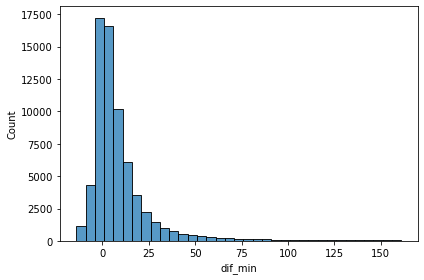

In [28]:
sns.histplot(data=df, 
            x='dif_min',
            binwidth=5)
#plt.xticks(rotation=70)
#plt.xlabel('Vlo-I',fontsize=1)
plt.tight_layout()

In [29]:
#atraso_15 : 1 si dif_min > 15, 0 si no.
df['atraso_15'] = np.where(df['dif_min'] > 15, 1, 0)

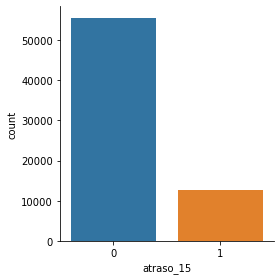

In [30]:
sns.catplot(data=df, 
            x='atraso_15', 
            kind="count",
            height=4, aspect=1)
#plt.xticks(rotation=70)
#plt.xlabel('Vlo-I',fontsize=1)
plt.tight_layout()

In [31]:
#funcion que calcula el periodo del día, requiere fechas en formato datetime.
def periodo_dia(hora):
    hora = datetime.time(hour = hora.hour, minute = hora.minute)
    if datetime.time(5,0) <= hora <= datetime.time(11,56):
        return 'mañana'
    elif datetime.time(12,0) <= hora <= datetime.time(18,59):
        return 'tarde'
    else:
        return 'noche'

In [32]:
#periodo_dia : mañana (entre 5:00 y 11:59), tarde (entre 12:00 y 18:59) y noche (entre 19:00 y 4:59), en base a Fecha-I .
df['periodo_dia'] = df.apply(lambda x: periodo_dia(x['Fecha-I']), axis=1)

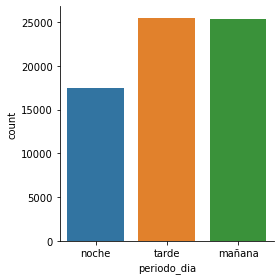

In [33]:
sns.catplot(data=df, 
            x='periodo_dia', 
            kind="count",
            height=4, aspect=1)
#plt.xticks(rotation=70)
#plt.xlabel('Vlo-I',fontsize=1)
plt.tight_layout()

In [34]:
#Guardamos variables creadas en archivo synthetic_features.csv 
df[['temporada_alta','dif_min','atraso_15','periodo_dia']] \
    .to_csv('synthetic_features.csv', index_label= False)

#### 3. ¿Cómo se compone la tasa de atraso por destino, aerolínea, mes del año, día de la semana, temporada, tipo de vuelo?
#### ¿Qué variables esperarías que más influyeran en predecir atrasos?

Al analizar los campos 'Des-I' y 'SIGLADES', notamos como hay codigos de destino duplicados en ciudades diferentes (Ej: Temuco y Punta Arenas ambos tienen asignado SCTE).
Para nuestros analisis y posterior modelado nos guiaremos solamente por el campo 'Des-I'.

In [35]:
destinos = df.groupby(['Des-I','SIGLADES'], as_index=False)['Vlo-I'].count()
destinos_duplicados = destinos[destinos['Des-I'].duplicated()]
destinos_duplicados.sort_values('Des-I')

,Des-I,SIGLADES,Vlo-I
6,KIAH,Washington,1
8,KJFK,Nueva York,382
36,SBGR,Sao Paulo,3569
40,SCBA,Puerto Montt,4
43,SCCI,Punta Arenas,2104
46,SCFA,Calama,1
48,SCIE,Puerto Montt,1
49,SCIE,Temuco,1
57,SCTE,Punta Arenas,1
58,SCTE,Temuco,5



Con las aerolinias sucede algo similar, por ejemplo, 'Grupo LATAM' opera multiples aerolineas, por lo tanto, usaremos el campo 'Emp-I' en nuestros analisis y así aseguramos trabajar a nivel de aerolinea y no de grupos.

In [36]:
aerolineas = df.groupby(['Emp-I','OPERA'], as_index=False)['Vlo-I'].count()
aerolineas_duplicados = aerolineas[aerolineas['OPERA'].duplicated()]
aerolineas_duplicados.sort_values('OPERA')

,Emp-I,OPERA,Vlo-I
17,LAN,Grupo LATAM,37611
18,LAP,Grupo LATAM,216
20,LNE,Grupo LATAM,1
21,LPE,Grupo LATAM,4
23,LXP,Grupo LATAM,9
28,TAM,Grupo LATAM,3049
19,LAW,Latin American Wings,1574


**Destinos:** Sobre los destinos, la media es de un 25% de vuelos con atraso con un dsipersión de un 23%. 
Salvo algunos casos puntuales que solo tienen un vuelo, hay un grupo importante de destinos que tiene un ratio de atrasos sobre el 30%.

In [37]:
atraso_destino = df.groupby(['Des-I'], as_index=False)['atraso_15'] \
    .agg(["sum", "count"]).reset_index() \
    .assign(ratio = lambda x: x['sum'] / x['count']) \
    .sort_values('ratio', ascending= False)

In [38]:
atraso_destino.head(10)

,Des-I,sum,count,ratio
2,EGYP,1,1,1.000000
55,SLCB,1,1,1.000000
52,SEQU,1,1,1.000000
51,SEQM,1,1,1.000000
26,SAWH,4,6,0.666667
63,YSSY,113,195,0.579487
62,YMML,21,38,0.552632
28,SAZS,1,2,0.500000
18,SAAR,54,136,0.397059
17,NZAA,135,361,0.373961


In [39]:
atraso_destino.describe()

,sum,count,ratio
count,64.00000,64.000000,64.000000
mean,197.09375,1065.718750,0.253194
std,281.23479,1496.220237,0.234241
min,0.00000,1.000000,0.000000
25%,11.50000,50.000000,0.135833
50%,60.00000,346.000000,0.190316
75%,312.00000,1609.250000,0.269350
max,1214.00000,5787.000000,1.000000


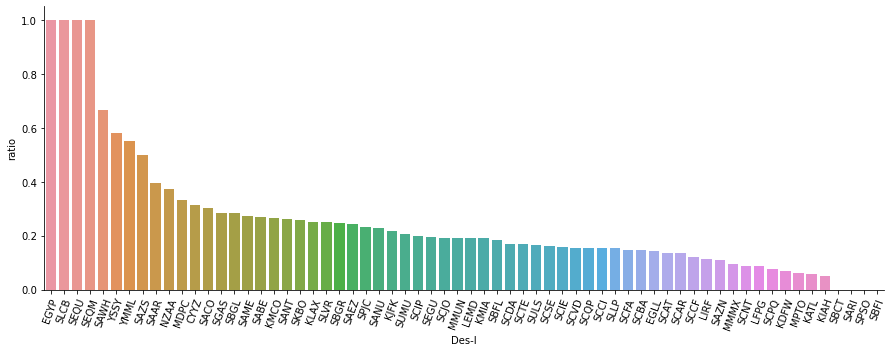

In [40]:
sns.catplot(data=atraso_destino, 
            x='Des-I', 
            y ='ratio',
            kind="bar",
            height=5, aspect=2.5)
plt.xticks(rotation=70)
plt.tight_layout()

**Aerolineas:** Se observa una distribución a los destinos. un 29% de atraso promedio con una dispersión de un 27%.

In [43]:
atraso_aerolinea = df.groupby(['Emp-I'], as_index=False)['atraso_15'] \
    .agg(["sum", "count"]).reset_index() \
    .assign(ratio = lambda x: x['sum'] / x['count']) \
    .sort_values('ratio', ascending= False)

In [44]:
atraso_aerolinea.head(10)

,Emp-I,sum,count,ratio
20,LNE,1,1,1.000000
11,DSM,2,2,1.000000
23,LXP,7,9,0.777778
25,PUE,30,49,0.612245
26,QFU,113,195,0.579487
21,LPE,2,4,0.500000
1,ACA,258,565,0.456637
19,LAW,642,1574,0.407878
15,JMR,39,100,0.390000
12,GLO,287,806,0.356079


In [45]:
atraso_aerolinea.describe()

,sum,count,ratio
count,30.000000,30.000000,30.000000
mean,420.466667,2273.533333,0.297233
std,1236.680561,7163.120100,0.268218
min,1.000000,1.000000,0.028490
25%,18.000000,123.750000,0.102578
50%,37.500000,343.000000,0.190849
75%,242.500000,1022.750000,0.403409
max,6453.000000,37611.000000,1.000000


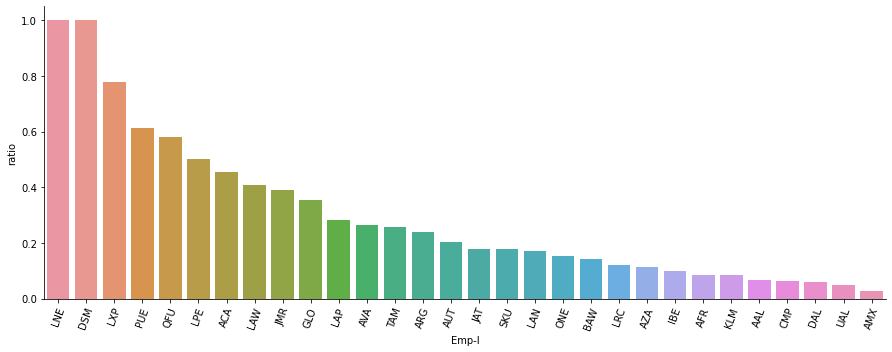

In [46]:
sns.catplot(data=atraso_aerolinea, 
            x='Emp-I', 
            y ='ratio',
            kind="bar",
            height=5, aspect=2.5)
plt.xticks(rotation=70)
plt.tight_layout()

**Mes:** Se observa una mayor tasa de atrasos en Julio, Octubre y Diciembre. Una menos tasa de atraso entre Marzo y Abril.

In [47]:
atraso_mes = df.groupby(['Mes-I'], as_index=False)['atraso_15'] \
    .agg(["sum", "count"]).reset_index() \
    .assign(ratio = lambda x: x['sum'] / x['count']) \
    .sort_values('Mes-I', ascending= True)

In [48]:
atraso_mes.head(12)

,Mes-I,sum,count,ratio
0,1,979,6108,0.160282
1,2,843,5561,0.151591
2,3,629,5480,0.114781
3,4,586,5021,0.116710
4,5,826,5239,0.157664
5,6,852,4982,0.171016
6,7,1758,5991,0.293440
7,8,996,5744,0.173398
8,9,967,5610,0.172371
9,10,1363,6032,0.225962


In [49]:
atraso_mes.describe()

,Mes-I,sum,count,ratio
count,12.000000,12.000000,12.000000,12.000000
mean,6.500000,1051.166667,5683.833333,0.182383
std,3.605551,366.872986,447.405213,0.052944
min,1.000000,586.000000,4982.000000,0.114781
25%,3.750000,838.750000,5419.750000,0.156146
50%,6.500000,973.000000,5677.000000,0.171693
75%,9.250000,1240.750000,6044.250000,0.204492
max,12.000000,1758.000000,6357.000000,0.293440


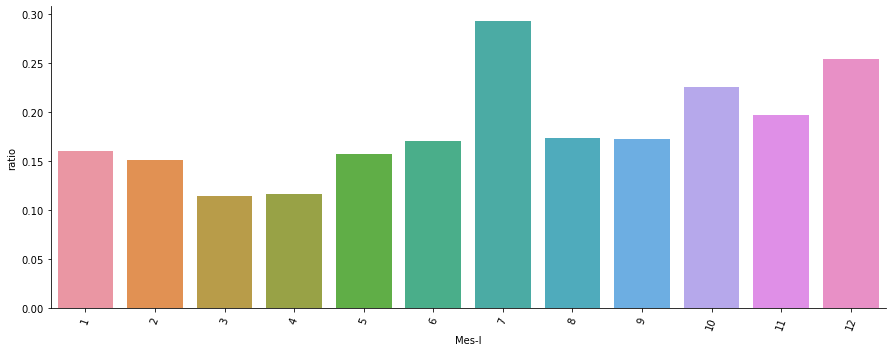

In [50]:
sns.catplot(data=atraso_mes, 
            x='Mes-I', 
            y ='ratio',
            kind="bar",
            height=5, aspect=2.5)
plt.xticks(rotation=70)
plt.tight_layout()

**Día:** Se observa una mayor tasa de atrasos los días viernes, lunes y martes.

In [51]:
atraso_dia = df.groupby(['DiaNom-I'], as_index=False)['atraso_15'] \
    .agg(["sum", "count"]).reset_index() \
    .assign(ratio = lambda x: x['sum'] / x['count']) \
    .sort_values('ratio', ascending= False)

In [52]:
atraso_dia.head()

,DiaNom-I,sum,count,ratio
0,Friday,2309,10332,0.223480
1,Monday,2031,10098,0.201129
4,Thursday,2040,10245,0.199122
6,Wednesday,1670,9726,0.171705
5,Tuesday,1638,9666,0.169460


In [53]:
atraso_dia.describe()

,sum,count,ratio
count,7.000000,7.000000,7.000000
mean,1802.000000,9743.714286,0.183896
std,335.978174,683.646281,0.024111
min,1327.000000,8306.000000,0.159764
25%,1618.500000,9696.000000,0.166038
50%,1670.000000,9833.000000,0.171705
75%,2035.500000,10171.500000,0.200125
max,2309.000000,10332.000000,0.223480


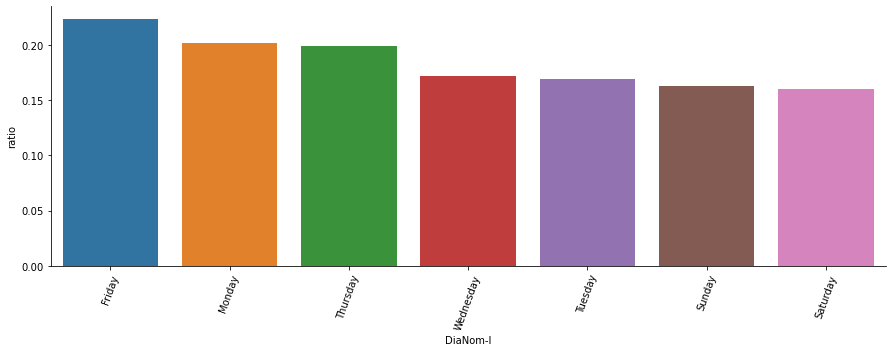

In [54]:
sns.catplot(data=atraso_dia, 
            x='DiaNom-I', 
            y ='ratio',
            kind="bar",
            height=5, aspect=2.5)
plt.xticks(rotation=70)
plt.tight_layout()

**Temporada:** Se observa una mayor tasa de atrasos en tempordada alta.

In [55]:
atraso_temporada = df.groupby(['temporada_alta'], as_index=False)['atraso_15'] \
    .agg(["sum", "count"]).reset_index() \
    .assign(ratio = lambda x: x['sum'] / x['count']) \
    .sort_values('ratio', ascending= False)

In [56]:
atraso_temporada.head()

,temporada_alta,sum,count,ratio
1,1,1605,7047,0.227756
0,0,11009,61159,0.180006


In [57]:
atraso_temporada.describe()

,temporada_alta,sum,count,ratio
count,2.000000,2.00000,2.000000,2.000000
mean,0.500000,6307.00000,34103.000000,0.203881
std,0.707107,6649.63217,38262.962144,0.033765
min,0.000000,1605.00000,7047.000000,0.180006
25%,0.250000,3956.00000,20575.000000,0.191944
50%,0.500000,6307.00000,34103.000000,0.203881
75%,0.750000,8658.00000,47631.000000,0.215819
max,1.000000,11009.00000,61159.000000,0.227756


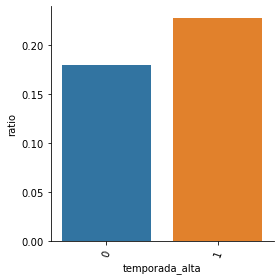

In [58]:
sns.catplot(data=atraso_temporada, 
            x='temporada_alta', 
            y ='ratio',
            kind="bar",
            height=4, aspect=1)
plt.xticks(rotation=70)
plt.tight_layout()

**Tipo Vuelo:** Se observa una mayor tasa de atrasos en vuelos internacionales.

In [59]:
atraso_tipo_vuelo = df.groupby(['TIPOVUELO'], as_index=False)['atraso_15'] \
    .agg(["sum", "count"]).reset_index() \
    .assign(ratio = lambda x: x['sum'] / x['count']) \
    .sort_values('ratio', ascending= False)

In [60]:
atraso_tipo_vuelo.head()

,TIPOVUELO,sum,count,ratio
0,I,7048,31240,0.225608
1,N,5566,36966,0.150571


In [61]:
atraso_tipo_vuelo.describe()

,sum,count,ratio
count,2.00000,2.000000,2.000000
mean,6307.00000,34103.000000,0.188089
std,1047.93225,4048.893429,0.053059
min,5566.00000,31240.000000,0.150571
25%,5936.50000,32671.500000,0.169330
50%,6307.00000,34103.000000,0.188089
75%,6677.50000,35534.500000,0.206849
max,7048.00000,36966.000000,0.225608


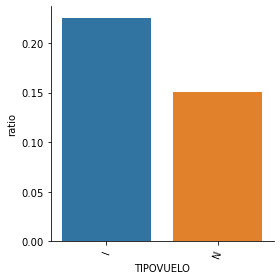

In [62]:
sns.catplot(data=atraso_tipo_vuelo, 
            x='TIPOVUELO', 
            y ='ratio',
            kind="bar",
            height=4, aspect=1)
plt.xticks(rotation=70)
plt.tight_layout()

Se observa una alta cardinalidad en las variables aerolineas y destinos.

Para el caso de los destinos, podemos extraer la primera letra del codigo destino, ya que indica el continente/zona del aeropuerto (https://en.wikipedia.org/wiki/ICAO_airport_code) y en conjunto con la variable distancia podemos aproximarnos a la ubicación, así disminuimos la cardinalidad.

En la variable aerolinea, probaremos incluirla tal cual, aplicando one-hot-encoding.

Tambien el día del del mes, lo reduciremos a semana en el mes, para evitar tanta cardinalidad,

In [63]:
df['Region-I'] = df['Des-I'].str[:1]

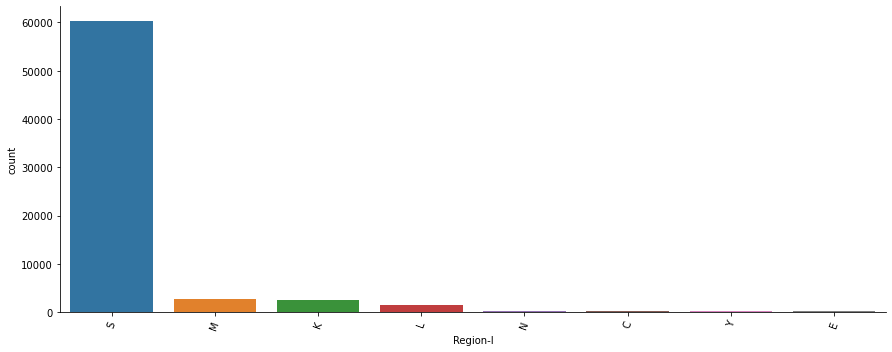

In [64]:
sns.catplot(data=df, 
            x='Region-I', 
            kind="count", 
            order = df['Region-I'].value_counts().index, 
            height=5, aspect=2.5)
plt.xticks(rotation=70)
#plt.xlabel('Vlo-I',fontsize=1)
plt.tight_layout()

In [65]:
import math
df['SemanaMes-I'] = df['Dia-I'].apply(lambda x: x/7).apply(lambda x: math.ceil(x))

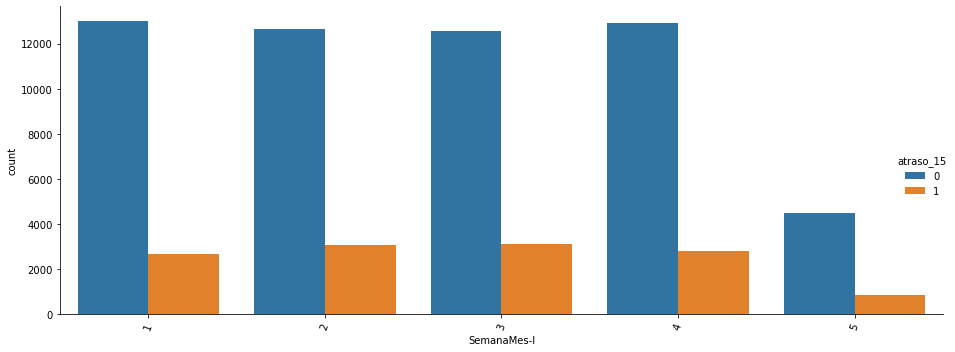

In [66]:
sns.catplot(data=df, 
            x='SemanaMes-I', 
            hue='atraso_15',
            kind="count", 
            height=5, aspect=2.5)
plt.xticks(rotation=70)
#plt.xlabel('Vlo-I',fontsize=1)
plt.tight_layout()

##### Entrena uno o varios modelos (usando el/los algoritmo(s) que prefieras) para estimar la probabilidad de atraso de un vuelo.


De acuerdo a lo comentado anteriormente, nuestra selección de variables para modelar el problema son las sigueintes:

In [67]:

variables = ['Region-I', 'Emp-I','distancia','TIPOVUELO', 'SemanaMes-I', 'Mes-I', 'DiaNom-I',
'temporada_alta', 'periodo_dia']
target = ['atraso_15']

In [68]:
#transformamos variables categoricas
df['Mes-I'] = df['Mes-I'].astype(str)
df['SemanaMes-I'] = df['SemanaMes-I'].astype(str)
df['temporada_alta'] = df['temporada_alta'].astype(str)

In [69]:
X_train, X_test, y_train, y_test = train_test_split(df[variables], df[target], test_size = .2, random_state = 22)

In [70]:
categorical_cols = [c for c in X_train.columns if X_train[c].dtype in [object]]
numerical_cols = [c for c in X_train.columns if X_train[c].dtype in [float, int, np.int64]]

In [109]:
#creamos pipeline
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy ='constant', fill_value = 0))
])

categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers =[
        ('numeric',numeric_transformer,numerical_cols),
        ('categorical',categorical_transformer,categorical_cols)
    ]
)

Entrenaremos utilizando el algoritmo lightgbm

In [110]:
pipe_lgbm = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('classifier', lgbm.LGBMClassifier())
])

In [111]:
lgbm_model = pipe_lgbm.fit(X_train,y_train)

c:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Haremos una busqueda de hiperparametros aleatoria, ojo con el parametro 'scale_pos_weight' para casos desbalanceados

In [112]:
grid_params_lgbm = {'classifier__learning_rate': np.arange(0.05,0.2,0.01), 
                   'classifier__n_estimators': np.arange(100,200,20),
                   'classifier__num_leaves': np.arange(30,100,10),
                   'classifier__colsample_bytree': np.arange(0.5,0.9,0.1),
                   'classifier__subsample': np.arange(0.1,0.9,0.1), 
                   'classifier__reg_alpha': np.arange(0.3,0.9,0.1), 
                   'classifier__reg_lambda': np.arange(0.3,0.9,0.1), 
                   'classifier__scale_pos_weight': np.arange(2,10,1)}

In [113]:
cv_lgbm = RandomizedSearchCV(
    estimator= lgbm_model,
    param_distributions= grid_params_lgbm,
    cv = 3,
    n_iter = 60,
    n_jobs=-1,
    scoring = 'recall',
    verbose= 2
)

In [114]:
cv_lgbm.fit(X_train,y_train)

Fitting 3 folds for each of 60 candidates, totalling 180 fits


c:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('numeric',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(fill_value=0,
                                                                                                              strategy='constant'))]),
                                                                               ['distancia']),
                                                                              ('categorical',
                                                                               Pipeline(steps=[('encoder',
                                                                                                OneHotEncoder(handle_unknown='ignore'))]),
                                                                               ['Region-I',
                                                                                'Emp-I',
                                                                                'TIPOVUELO',
                                                                                'SemanaMes-I',
                                                                                'Mes-I',
                                                                                'DiaNom-I'...
                                        'classifier__n_estimators': array([100, 120, 140, 160, 180]),
                                        'classifier__num_leaves': array([30, 40, 50, 60, 70, 80, 90]),
                                        'classifier__reg_alpha': array([0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                                        'classifier__reg_lambda': array([0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                                        'classifier__scale_pos_weight': array([2, 3, 4, 5, 6, 7, 8, 9]),
                                        'classifier__subsample': array([0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])},
                   scoring='recall', verbose=2)

In [115]:
cv_lgbm.best_params_

{'classifier__subsample': 0.3,
 'classifier__scale_pos_weight': 9,
 'classifier__reg_lambda': 0.5,
 'classifier__reg_alpha': 0.6000000000000001,
 'classifier__num_leaves': 40,
 'classifier__n_estimators': 160,
 'classifier__learning_rate': 0.05,
 'classifier__colsample_bytree': 0.7999999999999999}

Evalúa tu modelo. ¿Qué performance tiene? ¿Qué métricas usaste para evaluar esa performance y por qué? ¿Por qué
elegiste ese algoritmo en particular? ¿Qué variables son las que más influyen en la predicción? ¿Cómo podrías mejorar la
performance?

Para este problema se decidió darle mayor importancia a detectar casos reales con atraso, por lo tanto se le da improtancia a la meterica **Recall**, la cual alcanzo un valor de 0.90 en el set de testing. (En desmedro de que tenemos una precision de solo un 0.23, es decir, el modelo tiene una tasa de falsos positivos bien alta)

Escogimso el algoritmo lightgbm, ya que esta clase de algoritmos funciona muy bien en data tabular con alata cardoinalidad, si hacemos una rveisión de la literatura (https://sebastianraschka.com/blog/2022/deep-learning-for-tabular-data.html), vemos que la performance de algoritmos basados en arboles boosteados sigue siendo superior a metodos de redes neuronales en data tabular. Se escogió Lightgbm, por sobre Xgboost o Catboost, simplemente porque tiene una mejor performance en una humilde maquina como la mia.

In [116]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, plot_confusion_matrix

c:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


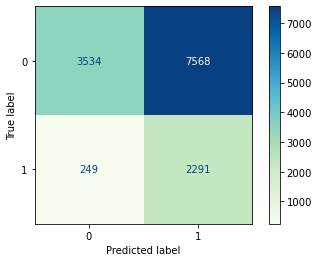

Precision: 0.232
Recall: 0.902
F1: 0.370
Accuracy: 0.427


In [117]:
y_pred = cv_lgbm.predict(X_test)
    
plot_confusion_matrix(cv_lgbm, X_test, y_test, cmap='GnBu')
plt.show()
print('Precision: %.3f' % precision_score(y_test, y_pred))
print('Recall: %.3f' % recall_score(y_test, y_pred))
print('F1: %.3f' % f1_score(y_test, y_pred))
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))

In [125]:
features_lgbm = list(cv_lgbm.best_estimator_[0].get_feature_names_out())
importancia_lgbm =cv_lgbm.best_estimator_.named_steps['classifier'].feature_importances_
feature_imprtance = pd.DataFrame({'Variable': features_lgbm, 'Importancia': importancia_lgbm}) \
.sort_values('Importancia', ascending= False)

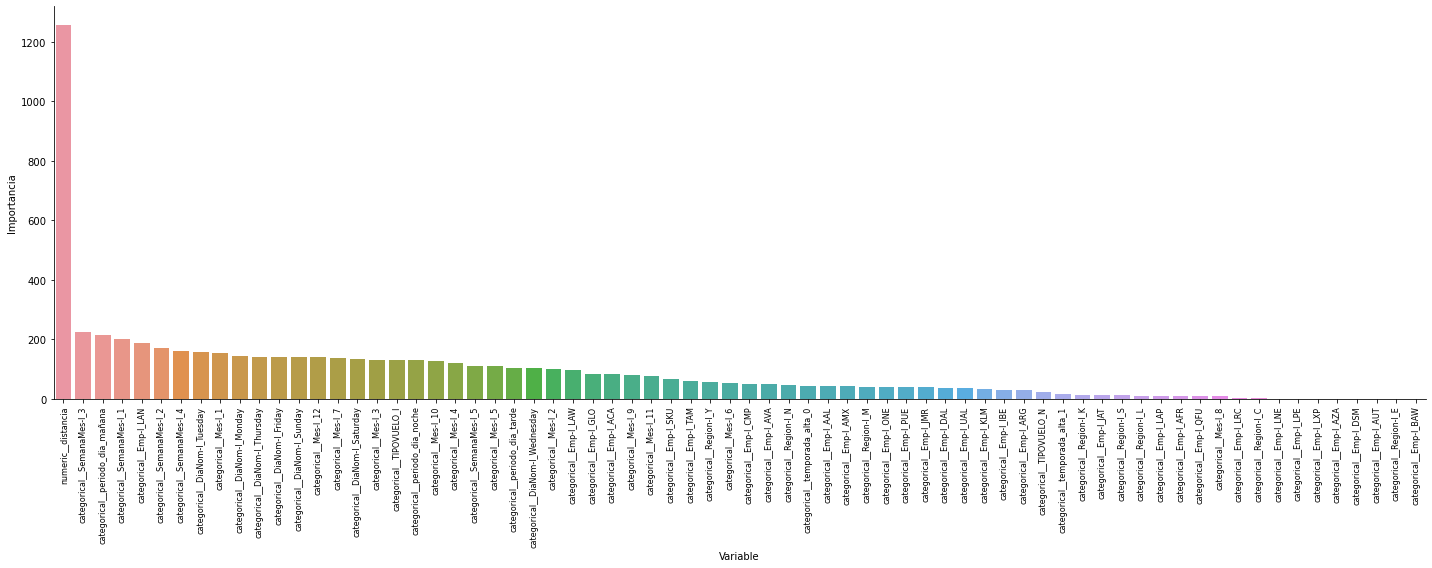

In [138]:
sns.catplot(data=feature_imprtance, 
            x='Variable', 
            y ='Importancia',
            kind="bar",
            height=8, aspect=2.5)
plt.xticks(rotation=90, size =  8)
plt.tight_layout()

Al analizar la importancia de las variables, vemos que la distancia es muy importante :) , seguido por  la semana del mes y periodo del día. Hay que pensar en una forma de disminuir la cantidad de aerolineas, ya que hay demasiado ruido con esa variable.

Creo que para mejorar la performance podriamos incorporar una variable que muestre el nivel de atraso de vuelos anteriores. Asi como en las consultas medicas si hay un atraso con un paciente, todas las siguientes consultas se atrasan, quizas en la operación de aviones suceda algo similar.